In [2]:
import pandas as pd
from pathlib import Path

# Pfad zur Excel-Datei (ausgehend von notebooks/)
data_path = Path("..") / "data" / "raw" / "PSP_Jan_Feb_2019.xlsx"

df = pd.read_excel(data_path)

print(df.shape)
df.head()



(50410, 8)


,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


C:\Users\rikad\AppData\Local\Temp\ipykernel_22648\1114971356.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["tmsp_min"] = df["tmsp"].dt.floor("T")


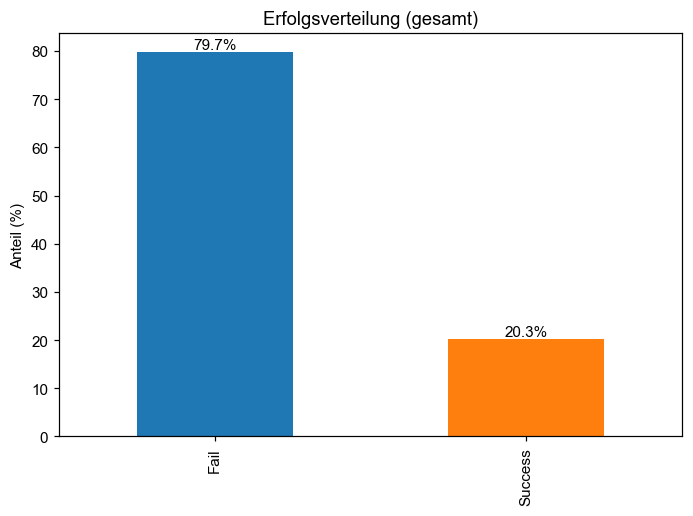

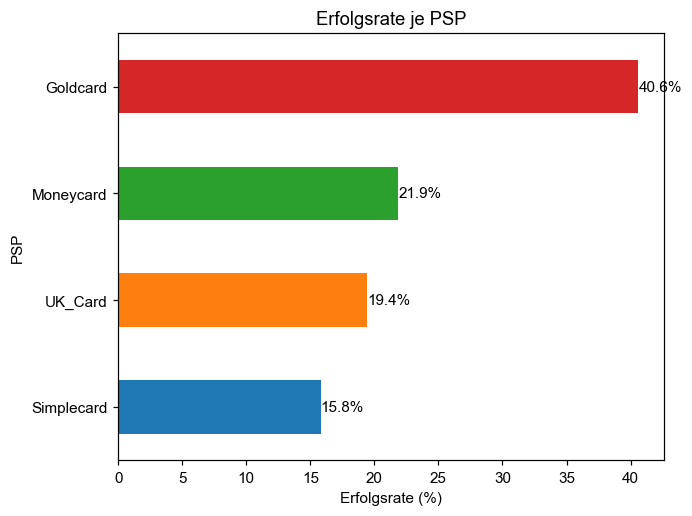

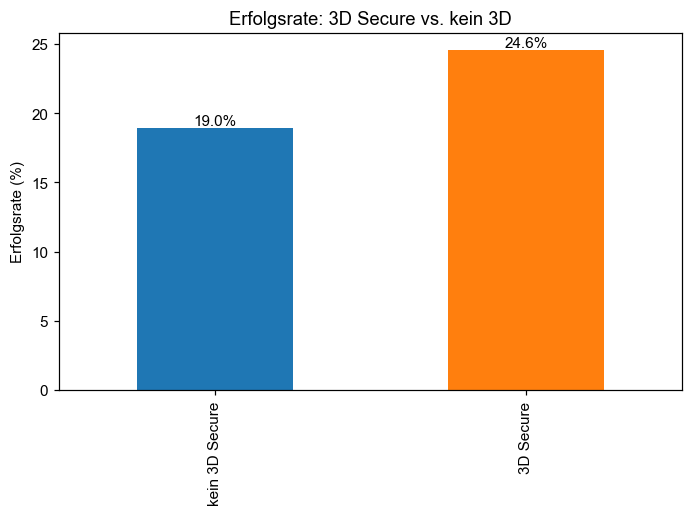

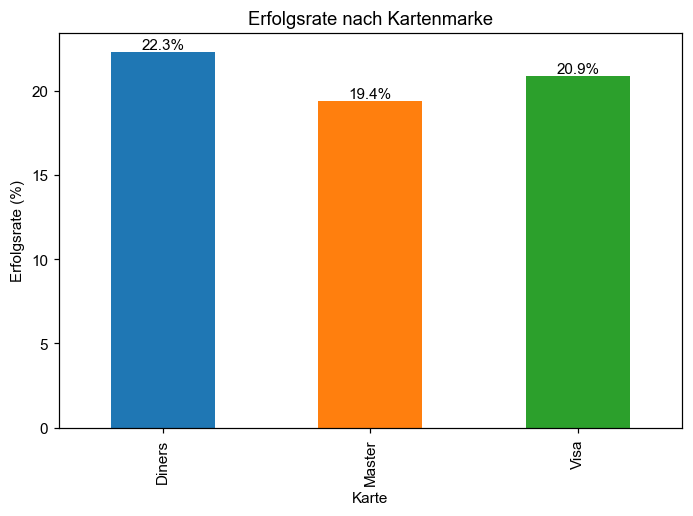

KeyError: 'hour'

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd  # nur falls du noch was mit df machst

# ---------------------------
# Stil & Ausgabeordner
# ---------------------------
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.dpi"] = 110
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# WICHTIG:
# Notebook liegt in notebooks/, figures/ liegt im Projektroot → also ../figures
FIGDIR = Path("../figures")
FIGDIR.mkdir(parents=True, exist_ok=True)

# (Optional) Fallback: is_retry erzeugen, falls noch nicht vorhanden
if "is_retry" not in df.columns:
    df["tmsp"] = pd.to_datetime(df["tmsp"], errors="coerce")
    df["tmsp_min"] = df["tmsp"].dt.floor("T")
    df["attempt_id"] = (
        df["tmsp_min"].astype(str)
        + "|" + df["country"].astype(str)
        + "|" + df["amount"].astype(str)
    )
    df["attempt_no"] = df.groupby("attempt_id").cumcount() + 1
    df["is_retry"] = (df["attempt_no"] > 1).astype(int)

# ---------------------------
# 1) Erfolgsverteilung gesamt
# ---------------------------
sr = df["success"].value_counts(normalize=True).rename({0: "Fail", 1: "Success"}) * 100

ax = sr.sort_index().plot(kind="bar", color=[colors[0], colors[1]])
ax.set_title("Erfolgsverteilung (gesamt)")
ax.set_ylabel("Anteil (%)")
ax.set_xlabel("")
for p, v in zip(ax.patches, sr.sort_index().values):
    ax.annotate(f"{v:.1f}%", (p.get_x() + p.get_width() / 2, v),
                ha="center", va="bottom")
plt.tight_layout()
plt.savefig(FIGDIR / "01_success_overall.png")
plt.show()

# ---------------------------
# 2) Erfolgsrate je PSP
# ---------------------------
psp_success = (df.groupby("PSP")["success"].mean().sort_values() * 100)

ax = psp_success.plot(kind="barh", color=colors[: len(psp_success)])
ax.set_title("Erfolgsrate je PSP")
ax.set_xlabel("Erfolgsrate (%)")
for p, v in zip(ax.patches, psp_success.values):
    ax.annotate(f"{v:.1f}%", (v, p.get_y() + p.get_height() / 2),
                va="center", ha="left")
plt.tight_layout()
plt.savefig(FIGDIR / "02_success_by_psp.png")
plt.show()

# ---------------------------
# 3) Erfolgsrate nach 3D Secure
# ---------------------------
sec = (df.groupby("3D_secured")["success"].mean() * 100)
sec.index = sec.index.map({0: "kein 3D Secure", 1: "3D Secure"})

ax = sec.plot(kind="bar", color=[colors[0], colors[1]])
ax.set_title("Erfolgsrate: 3D Secure vs. kein 3D")
ax.set_ylabel("Erfolgsrate (%)")
ax.set_xlabel("")
for p, v in zip(ax.patches, sec.values):
    ax.annotate(f"{v:.1f}%", (p.get_x() + p.get_width() / 2, v),
                ha="center", va="bottom")
plt.tight_layout()
plt.savefig(FIGDIR / "03_success_by_3d.png")
plt.show()

# ---------------------------
# 4) Erfolgsrate nach Kartenmarke
# ---------------------------
card = (df.groupby("card")["success"].mean() * 100)

ax = card.plot(kind="bar", color=colors[: len(card)])
ax.set_title("Erfolgsrate nach Kartenmarke")
ax.set_ylabel("Erfolgsrate (%)")
ax.set_xlabel("Karte")
for p, v in zip(ax.patches, card.values):
    ax.annotate(f"{v:.1f}%", (p.get_x() + p.get_width() / 2, v),
                ha="center", va="bottom")
plt.tight_layout()
plt.savefig(FIGDIR / "04_success_by_card.png")
plt.show()

# ---------------------------
# 5) Erfolgsrate nach Stunde
# ---------------------------
hour = (df.groupby("hour")["success"].mean() * 100).reindex(range(24))
labels = [f"{h} Uhr" for h in range(24)]

ax = hour.plot(marker="o", color=colors[0])
ax.set_title("Erfolgsrate nach Stunde")
ax.set_xlabel("Stunde")
ax.set_ylabel("Erfolgsrate (%)")
ax.set_xticks(range(24), labels=labels, rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIGDIR / "05_success_by_hour.png")
plt.show()

# ---------------------------
# 6) Erfolgsrate: Erst- vs. Wiederholungsversuch
# ---------------------------
retry = (df.groupby("is_retry")["success"].mean() * 100)
retry.index = retry.index.map({0: "Erstversuch", 1: "Wiederholungsversuch"})

ax = retry.plot(kind="bar", color=[colors[0], colors[1]])
ax.set_title("Erfolgsrate: Erst- vs. Wiederholungsversuch")
ax.set_ylabel("Erfolgsrate (%)")
ax.set_xlabel("")
for p, v in zip(ax.patches, retry.values):
    ax.annotate(f"{v:.1f}%", (p.get_x() + p.get_width() / 2, v),
                ha="center", va="bottom")
plt.tight_layout()
plt.savefig(FIGDIR / "06_success_by_retry.png")
plt.show()
